## Combine Kw-based models with LM-based models.
What happens? Can it improve further?

In [1]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import normalize

In [2]:
def zero_one_normalize(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X))


def trunc(values, decs=2):
    return np.trunc(values * 10**decs) / (10**decs)

In [3]:
base_model = "msmarco-MiniLM-L6-cos-v5"
LM_model = "SUM_docs_sum_wiki_sum"
LM_knowledges = pickle.load(open(f"../data/{base_model}_knowledge_gains.pkl", "rb"))[LM_model]
KW_knowledges = {l.split()[0]: float(l.strip().split()[-1]) for l in open("../calculated gain.csv").readlines()[1:]}
actual_learning = {k: LM_knowledges[k]["ALG"] for k in LM_knowledges}

user_ids = list(LM_knowledges.keys())

In [4]:
# LM_vector = np.array(zero_one_normalize([LM_knowledges[u]['final_sim'] for u in user_ids]))
# KW_vector = np.array(zero_one_normalize([KW_knowledges[u] for u in user_ids]))

LM_vector = np.array([LM_knowledges[u]["final_sim"] for u in user_ids])
KW_vector = np.array([KW_knowledges[u] for u in user_ids])

learning_vector = np.array([actual_learning[u] for u in user_ids])

best_alpha = 0.0
best_corr = 0.0

df_list = []


for alpha in trunc(np.arange(0, 1.01, 0.01)):
    beta = 1 - alpha
    final_score = alpha * LM_vector + beta * KW_vector
    corr, p_val = pearsonr(final_score, learning_vector)
    corr_vs_LM, p_LM = pearsonr(final_score, LM_vector)
    corr_vs_KW, p_KW = pearsonr(final_score, KW_vector)

    df_list.append(
        {
            "alpha": alpha,
            "pearson": corr,
            "pearson_p": p_val,
            "avg_learning": np.mean(learning_vector),
            "avg_KW_estimation": np.mean(KW_vector),
            "avg_LM_estimation": np.mean(LM_vector),
            "avg_comb_estimation": np.mean(final_score),
            "p_vs_LM": p_LM,
            "p_vs_KW": p_KW
        }
    )
    if corr > best_corr:
        best_p_val = p_val
        best_corr = corr
        best_alpha = alpha
    # print(f"{alpha:.2f} - {corr:.4f} ({p_val})")
print(f"Best alpha: {best_alpha:.2f} with pearson correlation of {best_corr:.5f}")
df = pd.DataFrame(df_list)

Best alpha: 0.77 with pearson correlation of 0.32642


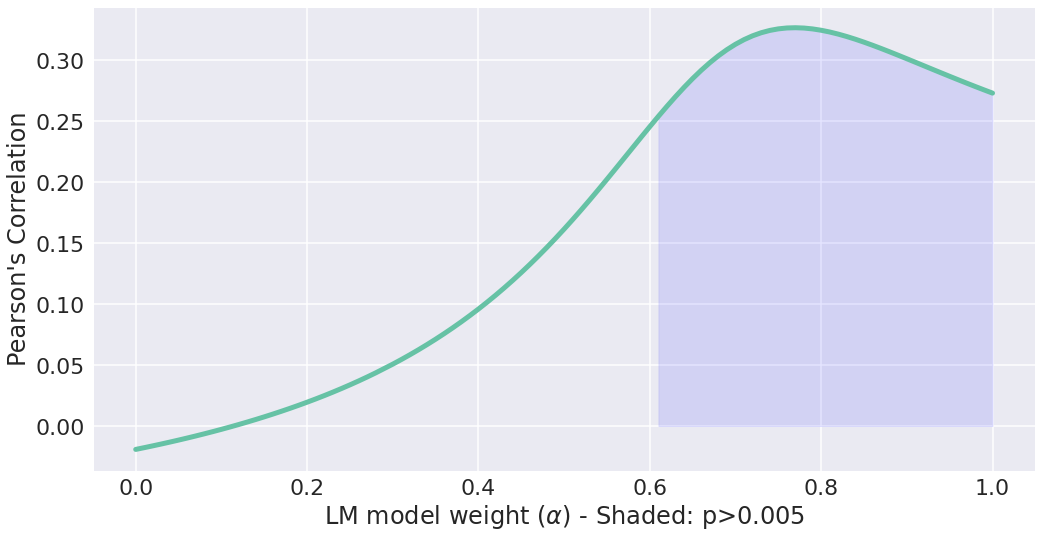

In [9]:

rel_level = 0.005

plt.figure()
sns.set(rc={"figure.figsize": (15, 8), "figure.autolayout": True})
sns.set_style("darkgrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=2.5, rc={"grid.linewidth": 1.5, "lines.linewidth": 5.0})

graph = sns.lineplot(data=df, x="alpha", y="pearson")
graph.set_ylabel("Pearson's Correlation")
graph.set_xlabel(r'LM model weight ($\alpha$) ' f"- Shaded: p>{rel_level}")

line = graph.axes.lines[0]
good_alphas = df[df.pearson_p < rel_level].alpha

x1 = good_alphas.values
y1 = df[df.alpha.isin(x1)].pearson
graph.fill_between(x1, y1, color="blue", alpha=0.1)

good_alphas_LM = df[df.p_vs_LM > rel_level].alpha
x1 = good_alphas_LM.values
y1 = df[df.alpha.isin(x1)].pearson
# graph.fill_between(x1, y1, color="red", alpha=0.1)


good_alphas_LM = df[df.p_vs_KW > rel_level].alpha
x1 = good_alphas_LM.values
y1 = df[df.alpha.isin(x1)].pearson
# graph.fill_between(x1, y1, color="orange", alpha=0.1)

In [36]:
num_rows = 20
years = list(range(1990, 1990 + num_rows))
data_preproc = pd.DataFrame(
    {
        "Year": years,
        "A": np.random.randn(num_rows).cumsum(),
        "B": np.random.randn(num_rows).cumsum(),
        "C": np.random.randn(num_rows).cumsum(),
        "D": np.random.randn(num_rows).cumsum(),
    }
)

In [38]:
pd.melt(data_preproc, ["Year"])

,Year,variable,value
0,1990,A,-0.698518
1,1991,A,-1.238838
2,1992,A,-2.127084
3,1993,A,-1.716415
4,1994,A,-1.341786
...,...,...,...
75,2005,D,0.189733
76,2006,D,0.832955
77,2007,D,-0.139715
78,2008,D,-0.634065
